# Day4 - Trying All Sorts of Classifiers (for the sake of stacking)

From my observation on day2 and day3, it seems like different training set (randomly splitted by train_test_split) causes different performance. However my model is definitely not overfitting, as my AUC is higher in the Kaggle public Leaderboard compared to my test accuracy and AUC.

Therefore, I guess that there are 'outliers' in the given training sample. Depending on how many of them are caught in my training split, the performance of my model changes somewhat. 

Thus, at this point, I should focus on removing such "outliers".

Also, I will try "stacking" method.

I am going to use 7 models that I know : LogisticRegression, K-NN, SVM, LDA, Quadratic Discriminant Analysys, RandomForest, and XGBoost.
Then, combine them and use a XGBClassifier as "meta-model".

In [1]:
from sklearn import datasets
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import LinearSVC, SVC
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.model_selection import GridSearchCV
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [2]:
data = pd.read_csv('train_final.csv')
X_pred_data = pd.read_csv('test_final.csv')
X_pred = np.asarray(X_pred_data.iloc[:, 1:25]).reshape(-1, 24)

In [3]:
X = np.asarray(data.iloc[:, 2:26]).reshape(-1, 24)
y = np.asarray(data.iloc[:, 1]).reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

First, I tune parametes of a RandomForest Classifier.

I am using some codes from https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d to see the effect of each parameters visually.

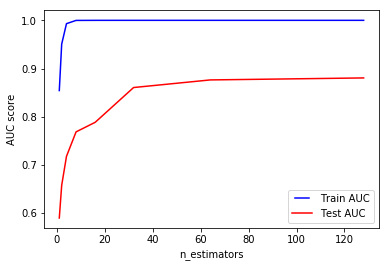

In [5]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 128]
train_results = []
test_results = []
for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
   rf.fit(X_train, y_train.ravel())
   train_pred = rf.predict_proba(X_train)[:, 1]
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict_proba(X_test)[:, 1]
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, 'b', label = "Train AUC")
line2 = plt.plot(n_estimators, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('n_estimators')
plt.show()

Seems like n_estimators = 100 (number of tress) is enough.

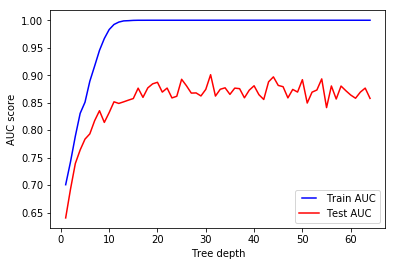

In [6]:
max_depths = np.linspace(1, 64, 64, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   rf = RandomForestClassifier(max_depth=max_depth, n_jobs=-1, n_estimators = 100)
   rf.fit(X_train, y_train.ravel())
   train_pred = rf.predict_proba(X_train)[:, 1]
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict_proba(X_test)[:, 1]
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
line1, = plt.plot(max_depths, train_results, 'b', label = "Train AUC")
line2 = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

Seems like max_depth=25 is good enough.

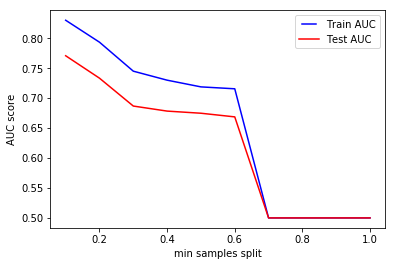

In [7]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
for min_samples_split in min_samples_splits:
   rf = RandomForestClassifier(min_samples_split=min_samples_split, n_estimators = 100, max_depth = 25)
   rf.fit(X_train, y_train.ravel())
   train_pred = rf.predict_proba(X_train)[:, 1]
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict_proba(X_test)[:, 1]
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
line1, = plt.plot(min_samples_splits, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples split')
plt.show()

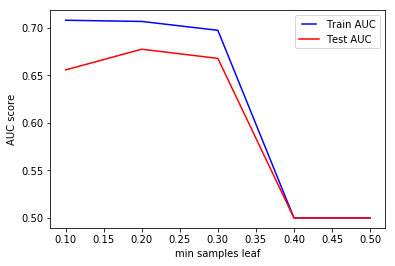

In [10]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
   rf = RandomForestClassifier(min_samples_leaf=min_samples_leaf, n_estimators = 100, max_depth = 25, min_samples_split = 0.6)
   rf.fit(X_train, y_train.ravel())
   train_pred = rf.predict_proba(X_train)[:, 1]
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict_proba(X_test)[:, 1]
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
line1, = plt.plot(min_samples_leafs, train_results, 'b', label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

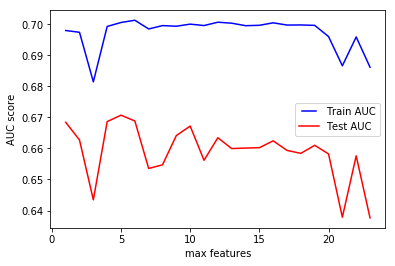

In [11]:
max_features = list(range(1,X_train.shape[1]))
train_results = []
test_results = []
for max_feature in max_features:
   rf = RandomForestClassifier(max_features=max_feature, n_estimators = 100, max_depth = 25, min_samples_split = 0.5, min_samples_leaf = 0.3)
   rf.fit(X_train, y_train.ravel())
   train_pred = rf.predict_proba(X_train)[:, 1]
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   train_results.append(roc_auc)
   y_pred = rf.predict_proba(X_test)[:, 1]
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   test_results.append(roc_auc)
line1, = plt.plot(max_features, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_features, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max features')
plt.show()

min_samples_split = 0.6, min_samples_leaf = 0.30, max_features = 5 seems optimal.

In [13]:
rf = RandomForestClassifier(n_estimators = 100, max_depth = 25, min_samples_split = 0.6, min_samples_leaf = 0.3, max_features = 5)
rf.fit(X_train, y_train.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.3, min_samples_split=0.6,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [14]:
print('Accuracy: %f' % metrics.accuracy_score(y_test, rf.predict(X_test)))
print('AUC: %f' %metrics.roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))

Accuracy: 0.952439
AUC: 0.672281


This is not good. So now I prepared XGBClassifier and RF as my base models.

Now I will tune LogisticRegression.

In [15]:
params_lr = [{
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['saga'],
    'max_iter': [1000]
}]
grid_lr = GridSearchCV(LogisticRegression(), param_grid = params_lr, scoring='roc_auc', n_jobs=2, iid=False, cv=3, verbose = 2)
grid_lr.fit(X_train, y_train.ravel())

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  24 out of  24 | elapsed:  2.7min finished
/Users/utsha/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=False, n_jobs=2,
       param_grid=[{'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1, 10], 'solver': ['saga'], 'max_iter': [1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [16]:
print("Chosen penalty: ", grid_lr.best_estimator_.get_params()['penalty'])
print("Strength(C): ", grid_lr.best_estimator_.get_params()['C'])

Chosen penalty:  l2
Strength(C):  0.01


In [17]:
lr = grid_lr.best_estimator_
lr.set_params(max_iter = 10000)
lr.fit(X_train, y_train.ravel())

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False)

In [18]:
print('Accuracy: %f' % metrics.accuracy_score(y_test, lr.predict(X_test)))
print('AUC: %f' %metrics.roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1]))

Accuracy: 0.952439
AUC: 0.506189


As expected, it scores a relatively bad AUC. Maybe I should not include LogisticRegression in my base model.

Now, I move onto quadratic discrimnant analysis. Since it's also linear, I guess it will be bad too.

In [19]:
params_qdr = [{'reg_param':[0, 0.1, 0.5, 1]}]
grid_qdr = GridSearchCV(QuadraticDiscriminantAnalysis(), param_grid = params_qdr, scoring='roc_auc', n_jobs=2, iid=False, cv=3, verbose = 2)
grid_qdr.fit(X_train, y_train.ravel())

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  12 out of  12 | elapsed:    0.5s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariance=False, store_covariances=None, tol=0.0001),
       fit_params=None, iid=False, n_jobs=2,
       param_grid=[{'reg_param': [0, 0.1, 0.5, 1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [20]:
print("chosen reg_param: ", grid_qdr.best_estimator_.get_params()['reg_param'])

chosen reg_param:  0.5


In [21]:
qdr = grid_qdr.best_estimator_
qdr.fit(X_train, y_train.ravel())

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.5,
               store_covariance=False, store_covariances=None, tol=0.0001)

In [22]:
print('Accuracy: %f' % metrics.accuracy_score(y_test, qdr.predict(X_test)))
print('AUC: %f' %metrics.roc_auc_score(y_test, qdr.predict_proba(X_test)[:, 1]))

Accuracy: 0.120732
AUC: 0.522440


As expected, Quadratic Discriminant Analysys does very bad job. I won't use it. 
I assume LDA will be similar, so I will skip testing it.

Now I move onto SVM.

In [47]:
params_svc = [{
    #'kernel': ['poly', 'rbf', 'sigmoid'],
    'kernel': ['rbf'],
    #'coef0': [0, 0.5, 1],
    'probability': [True]
}]

In [46]:
grid_svc = GridSearchCV(SVC(), param_grid = params_svc, scoring='roc_auc', n_jobs=2, iid=False, cv=3, verbose = 2)
grid_svc.fit(X_train, y_train.ravel())

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: 

GridsearchCV took really long time, so I skiped it. Otherwise I was losing my 5 submissions today.

In [ ]:
print("chosen kernel: ", grid_svc.best_estimator_.get_params()['kernel'])
print("chosen coef0: ", grid_svc.best_estimator_.get_params()['coef0'])

In [48]:
#svc = grid_svc.best_estimator
svc = SVC(probability=True)
svc.fit(X_train, y_train.ravel())

/Users/utsha/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [49]:
print('Accuracy: %f' % metrics.accuracy_score(y_test, svc.predict(X_test)))
print('AUC: %f' %metrics.roc_auc_score(y_test, svc.predict_proba(X_test)[:, 1]))

Accuracy: 0.945122
AUC: 0.500000


Although AUC is bad, I may consider using it. AUC = 0.50 is not significantly lower than that of XGBClassifier which is around 0.65.

Finally, I will try K-NN.

In [50]:
params_knn = [{
    'n_neighbors':[5],
    'p': [1, 2, 3],
}]

In [52]:
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid = params_knn, scoring='roc_auc', n_jobs=2, iid=False, cv=3, verbose = 2)
grid_knn.fit(X_train, y_train.ravel())

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed:   33.9s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=False, n_jobs=2,
       param_grid=[{'n_neighbors': [5], 'p': [1, 2, 3]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [53]:
print("chosen 'p': ", grid_knn.best_estimator_.get_params()['p'])

chosen 'p':  1


In [54]:
params_knn2 = [{
    'n_neighbors':[5, 10, 15],
    'p': [1],
}]

In [55]:
grid_knn2 = GridSearchCV(KNeighborsClassifier(), param_grid = params_knn2, scoring='roc_auc', n_jobs=2, iid=False, cv=3, verbose = 2)
grid_knn2.fit(X_train, y_train.ravel())

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   9 out of   9 | elapsed:   16.4s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=False, n_jobs=2,
       param_grid=[{'n_neighbors': [5, 10, 15], 'p': [1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [56]:
print("chosen 'n_neighbors': ", grid_knn2.best_estimator_.get_params()['n_neighbors'])

chosen 'n_neighbors':  10


Luckily, from above 2 gridsearch, I was able to get optimal 'p' and 'n_neighbors'.

In [58]:
knn = grid_knn2.best_estimator_
knn.fit(X_train, y_train.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=10, p=1,
           weights='uniform')

In [59]:
print('Accuracy: %f' % metrics.accuracy_score(y_test, knn.predict(X_test)))
print('AUC: %f' %metrics.roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1]))

Accuracy: 0.946341
AUC: 0.521577


Again, such low AUC score implies that K-NN is useless for stacking.

Now, I have prepared all base models. I move on to try stacking.

In [6]:
xgb = XGBClassifier(colsample_bytree=0.65, gamma=0.1,
       learning_rate=0.05, max_depth=5,
       min_child_weight=5, n_estimators=100, objective='binary:logistic',
      reg_alpha=1, reg_lambda=1,
      subsample=0.85, verbosity=1, n_jobs=-1)
    
rf = RandomForestClassifier(n_estimators = 100, max_depth = 25, n_jobs=-1)
    
knn =  KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', n_jobs=-1, n_neighbors=10, p=1)

In [7]:
xgb.fit(X_train, y_train.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.65, gamma=0.1,
       learning_rate=0.05, max_delta_step=0, max_depth=5,
       min_child_weight=5, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=None, subsample=0.85, verbosity=1)

In [8]:
X_train2 = np.hstack((X_train, xgb.predict(X_train).reshape(-1, 1)))

In [9]:
X_test2 = np.hstack((X_test, xgb.predict(X_test).reshape(-1, 1)))

In [10]:
X_pred.shape

(16385, 24)

In [11]:
tmp = xgb.predict(X_pred).reshape(-1, 1)

In [12]:
tmp.shape

(16385, 1)

In [ ]:
X_pred2 = np.hstack((X_pred, tmp))

In [12]:
knn.fit(X_train, y_train.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=10, p=1,
           weights='uniform')

In [8]:
X_train3 = np.hstack((X_train2, knn.predict(X_train2).reshape(-1, 1)))
X_test3 = np.hstack((X_test2, knn.predict(X_test2).reshape(-1, 1)))
X_pred3 = np.hstack((X_pred2, knn.predict(X_pred2).reshape(-1, 1)))

In [8]:
rf.fit(X_train, y_train.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [10]:
# y_submission14 = pd.DataFrame(rf.predict_proba(X_pred)[:, 1], columns = ['Y']) 
# y_submission14['Id'] = X_pred_data['Id']
# y_submission14 = y_submission14.reindex(columns=["Id", "Y"])
# y_submission14.to_csv("submission14_uk734.csv", index=False)

In [13]:
# y_submission15 = pd.DataFrame(knn.predict_proba(X_pred)[:, 1], columns = ['Y']) 
# y_submission15['Id'] = X_pred_data['Id']
# y_submission15 = y_submission15.reindex(columns=["Id", "Y"])
# y_submission15.to_csv("submission15_uk734.csv", index=False)